In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from skimage import color, io, morphology

# dataset generator

In [2]:
def build_file_dict(folder):
    file_dict = {}
    for foldername, subfolders, filenames in os.walk(folder):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            file_dict[filename] = file_path
    return file_dict

In [3]:
working_directory =  r"/home/crest/z/hwang_Pro/data/2023_hokkaido_potato"
img_folder = os.path.join(working_directory, 'images')
img_dict = build_file_dict(img_folder)

# mask by cv

In [4]:
def get_mask(img_path):
    img_np = plt.imread(img_path)

    h,w,d = img_np.shape

    # convert to LAB color space
    lab_image = color.rgb2lab(img_np)

    # get color channel
    a_channel = lab_image[:, :, 1]
    b_channel = lab_image[:, :, 2]

    # set channel threshold
    color_threshold = 20  # 颜色阈值

    # 创建掩膜
    mask = np.logical_or(a_channel > color_threshold, b_channel > color_threshold)

    # fill holes in the mask
    filled_mask = morphology.remove_small_holes(mask, area_threshold=h*w*0.005)
    cleaned_mask = morphology.remove_small_objects(filled_mask, min_size=h*w*0.005)


    # 将掩膜应用于原始图像
    result = np.copy(img_np)
    result[~cleaned_mask] = 0

    return cleaned_mask, img_np, result

In [5]:
img_list = list(img_dict.keys())
random_img = random.choice(img_list)

img_np = io.imread(img_dict[random_img])

In [6]:
mask, img_np, result = get_mask(img_dict[random_img])

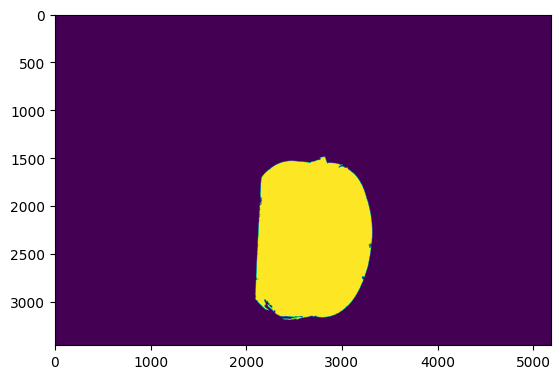

In [7]:
plt.imshow(mask)

# cascadpsp refine

In [8]:
from cascade_psp import Refiner

In [9]:
psp_refiner = Refiner(device='cuda:0', model_path='psp_models/cascade_psp')

In [26]:
output = psp_refiner.refine(img_np, mask*255, fast=False, L=900)

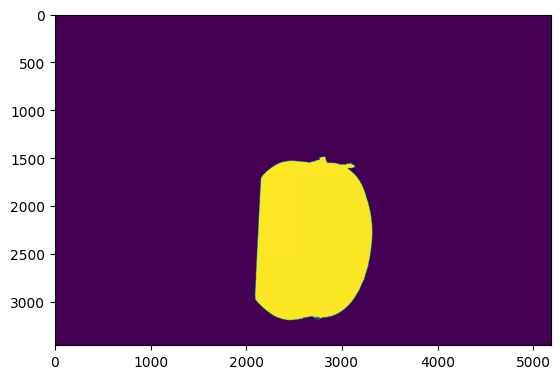

In [13]:
plt.imshow(output)

In [14]:
output.max()

255

In [19]:
mask_color = np.copy(img_np)
mask_color[output==0] = 0

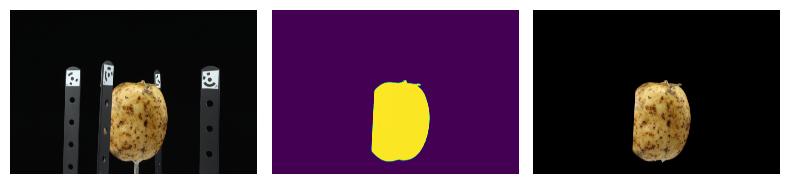

In [25]:
fig,ax = plt.subplots(1,3, figsize=(8,18))

ax[0].imshow(img_np)
ax[0].axis('off')

ax[1].imshow(output)
ax[1].axis('off')

ax[2].imshow(mask_color)
ax[2].axis('off')

plt.tight_layout()

plt.show()